In [1]:
!pip install gdown
!pip install tensorflow_hub

import os
import zipfile
import gdown
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    return audio

def extract_embeddings(audio):
    _, embeddings, _ = yamnet_model(audio)
    return embeddings.numpy()


In [3]:
dataset_url = "https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5"
dataset_zip = "ravdess.zip"
gdown.download(dataset_url, dataset_zip, quiet=False)

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("ravdess_data")

DATASET_PATH = "ravdess_data"


Downloading...
From (original): https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5
From (redirected): https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5&confirm=t&uuid=dd537b00-0841-448f-8fff-d7fdec3bd3fa
To: /content/ravdess.zip
100%|██████████| 450M/450M [00:07<00:00, 61.7MB/s]


In [4]:
def augment_audio(audio, sr):
    audio_stretched = librosa.effects.time_stretch(audio, rate=1.1)
    audio_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    noise = np.random.normal(0, 0.01, len(audio))
    audio_noisy = audio + noise
    return [audio_stretched, audio_shifted, audio_noisy]

X, y = [], []

for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            audio = preprocess_audio(file_path)
            embedding_seq = extract_embeddings(audio)

            label = file.split('-')[2]
            X.append(embedding_seq)
            y.append(label)

            augmented_audios = augment_audio(audio, sr=16000)
            for aug_audio in augmented_audios:
                aug_embedding_seq = extract_embeddings(aug_audio)
                X.append(aug_embedding_seq)
                y.append(label)

print(f"Total data after augmentation: {len(X)} samples")

X_padded = pad_sequences(X, padding='post', dtype='float32')
print("Shape after padding:", X_padded.shape)

num_samples, max_len, emb_dim = X_padded.shape
X_reshaped = X_padded.reshape(-1, emb_dim)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, max_len, emb_dim)


Total data after augmentation: 11520 samples
Shape after padding: (11520, 10, 1024)


In [5]:
def label_to_multilabel(label):
    mapping = {
        '01': ['neutral'],
        '02': ['calm'],
        '03': ['happy'],
        '04': ['sad'],
        '05': ['angry'],
        '06': ['fearful'],
        '07': ['disgust'],
        '08': ['surprised']
    }
    return mapping.get(label, [])

multi_labels = [label_to_multilabel(lab) for lab in y]

mlb = MultiLabelBinarizer()
y_multi_encoded = mlb.fit_transform(multi_labels)

print("Example Multi-Label Encoding:", y_multi_encoded[0])
print("Emotion Classes:", mlb.classes_)


Example Multi-Label Encoding: [0 0 1 0 0 0 0 0]
Emotion Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [6]:
# 1. Masking function + Filter valid sequences
def mask_embeddings(X, mask_rate=0.1):
    X_masked = np.copy(X)
    for i in range(X.shape[0]):
        num_mask = int(X.shape[1] * mask_rate)
        mask_indices = np.random.choice(X.shape[1], num_mask, replace=False)
        X_masked[i, mask_indices, :] = 0

    # Setelah masking, filter out sequences yang kosong total
    valid_indices = np.where(np.sum(np.any(X_masked != 0, axis=-1), axis=1) > 0)[0]
    X_masked = X_masked[valid_indices]
    X_target = X[valid_indices]  # target harus sama valid

    return X_masked, X_target

# 2. Apply masking + filter
X_ssl_input, X_ssl_target = mask_embeddings(X_scaled)

print("Final shape for SSL input:", X_ssl_input.shape)
print("Final shape for SSL target:", X_ssl_target.shape)

# 3. Build SSL model
def build_ssl_model(max_len, emb_dim):
    inputs = tf.keras.Input(shape=(max_len, emb_dim))
    x = tf.keras.layers.Masking(mask_value=0.)(inputs)
    x = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(64), return_sequences=True)(x)
    x = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True)(x)

    # Apply Dense to each timestep manually without TimeDistributed
    x = tf.keras.layers.Dense(emb_dim)(x)

    model = tf.keras.Model(inputs, x)
    return model


# Build SSL model
ssl_model = build_ssl_model(max_len, emb_dim)

# Compile
ssl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mae')

# Train
ssl_model_history = ssl_model.fit(X_ssl_input, X_ssl_target,
                                  epochs=50,
                                  batch_size=32,
                                  validation_split=0.2,
                                  callbacks=[
                                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                                  ])




Final shape for SSL input: (11520, 10, 1024)
Final shape for SSL target: (11520, 10, 1024)
Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.4213 - val_loss: 0.2521
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2130 - val_loss: 0.1594
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1591 - val_loss: 0.1520
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1514 - val_loss: 0.1456
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1439 - val_loss: 0.1383
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1375 - val_loss: 0.1323
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1291 - val_loss: 0.1240
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1223 - val_loss: 0.1214
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1194 - val_loss: 0.1182
Epoch 10/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1174 - val_loss: 0.1165
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms

In [7]:
fine_tune_model = tf.keras.Sequential([
    ssl_model,
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(mlb.classes_), activation='sigmoid')
])

fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_multi_encoded, test_size=0.2, random_state=42)

fine_tune_model_history = fine_tune_model.fit(X_train, y_train,
                                              epochs=100,
                                              batch_size=32,
                                              validation_data=(X_test, y_test),
                                              callbacks=[
                                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
                                              ])



Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1479 - loss: 0.5007 - val_accuracy: 0.3329 - val_loss: 0.3415 - learning_rate: 5.0000e-04
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2440 - loss: 0.3823 - val_accuracy: 0.3954 - val_loss: 0.3105 - learning_rate: 5.0000e-04
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3252 - loss: 0.3485 - val_accuracy: 0.4505 - val_loss: 0.2915 - learning_rate: 5.0000e-04
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3867 - loss: 0.3227 - val_accuracy: 0.4701 - val_loss: 0.2783 - learning_rate: 5.0000e-04
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4236 - loss: 0.3077 - val_accuracy: 0.4974 - val_loss: 0.2668 - learning_rate: 5.0000e-04
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4492 - loss: 0.2943 - val_accuracy: 0.5217 - val_loss: 0.2562 - learning_rate: 5.0000e-04
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - a

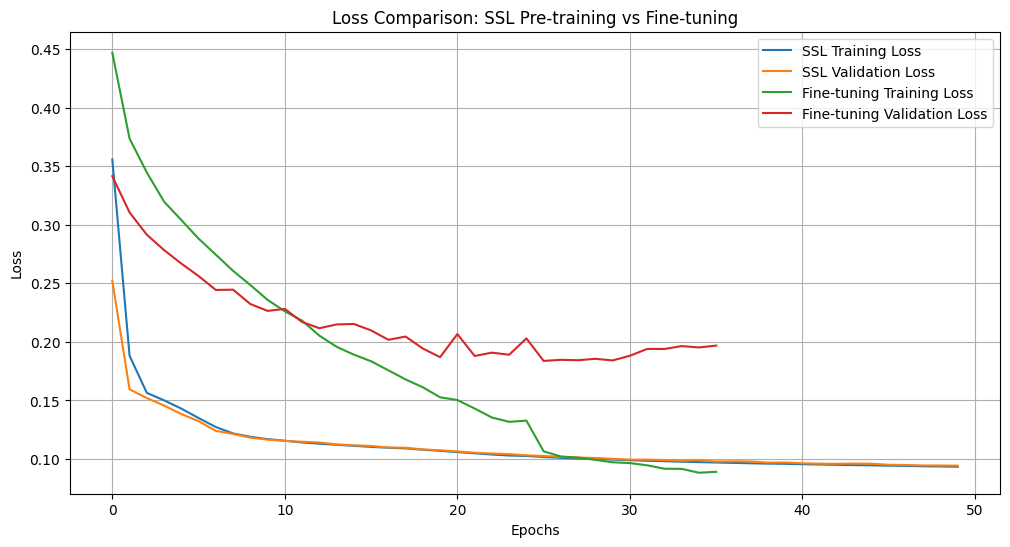

In [8]:
def plot_ssl_finetune_loss(ssl_history, finetune_history):
    plt.figure(figsize=(12, 6))
    plt.plot(ssl_history.history['loss'], label='SSL Training Loss')
    plt.plot(ssl_history.history['val_loss'], label='SSL Validation Loss')
    plt.plot(finetune_history.history['loss'], label='Fine-tuning Training Loss')
    plt.plot(finetune_history.history['val_loss'], label='Fine-tuning Validation Loss')
    plt.title('Loss Comparison: SSL Pre-training vs Fine-tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_ssl_finetune_loss(ssl_model_history, fine_tune_model_history)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


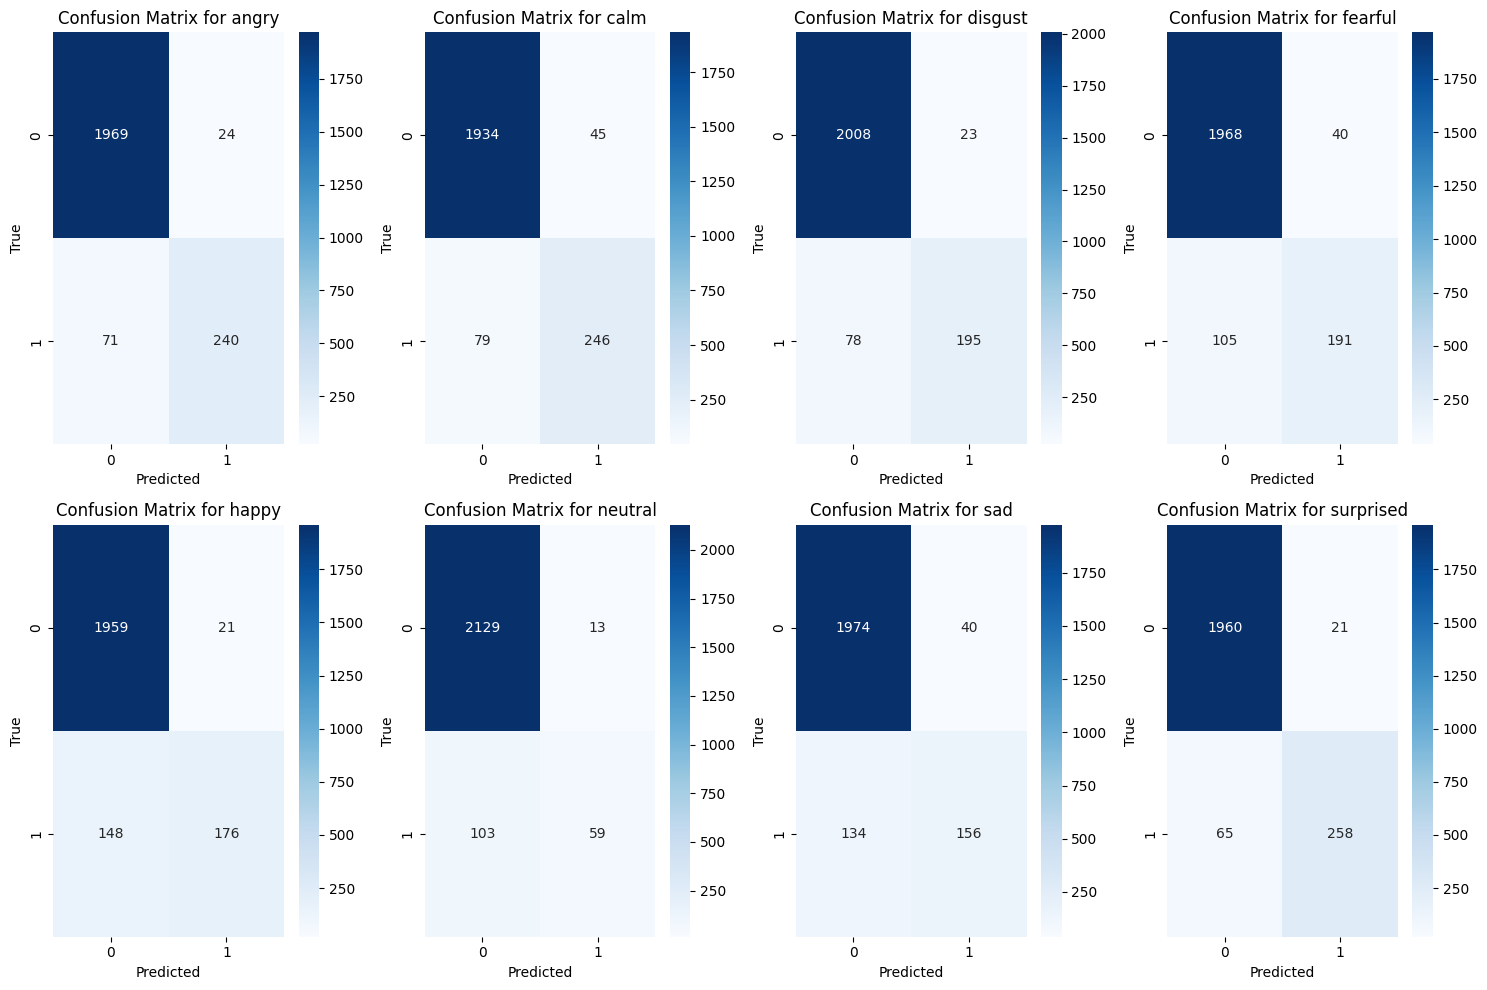

In [9]:
def plot_multi_label_confusion(y_true, y_pred, labels):
    y_pred_thresh = (y_pred > 0.5).astype(int)
    conf_matrices = multilabel_confusion_matrix(y_true, y_pred_thresh)

    fig, axes = plt.subplots(2, int(np.ceil(len(labels) / 2)), figsize=(15, 10))
    axes = axes.flatten()

    for i, cm in enumerate(conf_matrices):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {labels[i]}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

y_pred_probs = fine_tune_model.predict(X_test)
plot_multi_label_confusion(y_test, y_pred_probs, labels=mlb.classes_)


In [10]:
def predict_emotions_audio(file_path, yamnet_model, fine_tune_model, scaler, max_len, emb_dim, mlb):
    audio = preprocess_audio(file_path)

    # Ini diperbaiki sedikit untuk keamanan
    scores, embeddings, spectrogram = yamnet_model(audio)
    embeddings = embeddings.numpy()

    padded_seq = pad_sequences([embeddings], maxlen=max_len, padding='post', dtype='float32')
    padded_seq_scaled = scaler.transform(padded_seq.reshape(-1, emb_dim)).reshape(1, max_len, emb_dim)

    pred_probs = fine_tune_model.predict(padded_seq_scaled)[0]

    print("\nEmotion Probabilities:")
    for label, prob in zip(mlb.classes_, pred_probs):
        print(f"{label}: {prob*100:.2f}%")

    strong_emotions = [label for label, prob in zip(mlb.classes_, pred_probs) if prob > 0.5]
    print("\nDetected Strong Emotions (>50% confidence):", strong_emotions)



In [11]:
predict_emotions_audio('/content/Test1.wav', yamnet_model, fine_tune_model, scaler, max_len, emb_dim, mlb)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Emotion Probabilities:
angry: 0.00%
calm: 0.00%
disgust: 0.00%
fearful: 69.60%
happy: 5.55%
neutral: 0.00%
sad: 0.00%
surprised: 0.54%

Detected Strong Emotions (>50% confidence): ['fearful']
